In [6]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../paretoviz')
from paretoviz import plotting as pplt
from paretoviz import decorator as dcor
from paretoviz.utils import fmt
from paretoviz.utils import vectorops as vops
from paretoviz.decorator import Arrow3D

# Do all these plots with centroid based coloring

# rawfpath = "../data/spherical/spherical-3d.out"
# rawfpath = "../data/spherical/spherical-4d.out"
# rawfpath = "../data/spherical/spherical-8d.out"

# rawfpath = "../data/knee/knee-3d.out"
# rawfpath = "../data/knee/knee-4d.out"
# rawfpath = "../data/knee/knee-8d.out"

# rawfpath = "../data/line-surface/line-3d.out"
rawfpath = "../data/line-surface/line-4d.out"
# rawfpath = "../data/line-surface/line-6d.out"
# rawfpath = "../data/line-surface/line-8d.out"

# rawfpath = "../data/carcrash/carcrash-3d.out"
# rawfpath = "../data/carcrash/carcrash-c1/carcrash-c1-3d.out"
# rawfpath = "../data/carcrash/carcrash-c2/carcrash-c2-3d.out"

# Do all these plots with constraint based coloring

# rawfpath = "../data/knee-const/knee-const-3d.out"
# rawfpath = "../data/knee-const/knee-const-4d.out"
# rawfpath = "../data/knee-const/knee-const-8d.out"

# rawfpath = "../data/knee-const-mod/knee-const-mod-3d.out"
# rawfpath = "../data/knee-const-mod/knee-const-mod-4d.out"

# rawfpath = "../data/isolated/isolated-3d.out"
# rawfpath = "../data/isolated/isolated-4d.out"
# rawfpath = "../data/isolated/isolated-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-4d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-5d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-c1/c2dtlz2-c1-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c2/c2dtlz2-c2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c3/c2dtlz2-c3-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c4/c2dtlz2-c4-3d.out"

# rawfpath = "../data/gaa-das/gaa-das-10d.out"
# rawfpath = "../data/gaa-lhs/gaa-lhs-10d.out"

# some ML data sets
# rawfpath = "../data/airofoil/airofoil-5d.out"
# rawfpath = "../data/banknote/banknote-4d.out"
# rawfpath = "../data/blood/blood-4d.out"
# rawfpath = "../data/cccp/cccp-4d.out"
# rawfpath = "../data/concrete/concrete-8d.out"
# rawfpath = "../data/iris/iris-4d.out"
# rawfpath = "../data/mammogram/mammogram-5d.out"
# rawfpath = "../data/wil/wil-7d.out"
# rawfpath = "../data/yeast/yeast-8d.out"

# do visualization based on distance from the centroid?
docentroid = False

# get the path and filename from the rawfpath
path, rawfile = os.path.split(rawfpath)
# get the prefix
prefix = rawfile.split('.')[0]

# load the normalized points
points = fmt.load(os.path.join(path, prefix + "-norm.out"))

# load the CV values
cvfpath = os.path.join(path, prefix + "-cv.out")
if not docentroid and os.path.exists(cvfpath):
    cv = [v[0] if len(v) == 1 else v for v in fmt.load(cvfpath)]
    [low, up] = vops.get_bound(cv)
    cv = vops.normalize(cv, low, up)
    color = dcor.recolor_by_cv(cv)
else:
    color = dcor.recolor_by_centroid(points)

# load the normalized trade-off values
mufpath = os.path.join(path, prefix + "-norm-mu.out")
knee_idx = None
if os.path.exists(mufpath):
    mu = [v[0] if len(v) == 1 else v for v in fmt.load(mufpath)]
    # resize the points w.r.t. trade-offs
    size = dcor.rescale_by_tradeoff(mu)
    (color, knee_idx) = dcor.recolor_by_tradeoff(size, color)

# load the class labels
classfpath = os.path.join(path, prefix + "-class.out")
if os.path.exists(classfpath):
    labels = [v[0] if len(v) == 1 else v for v in \
            fmt.load(classfpath, dtype = dcor.dtypes[prefix])]
    color = dcor.recolor_by_labels(labels, dtype = dcor.dtypes[prefix])
    size = [5.0 for _ in range(len(points))]

# alpha values
alpha = [0.2, 0.8] # alpha for plots with knee
# alpha = [1.0, 1.0] # alpha for general case

<IPython.core.display.Javascript object>


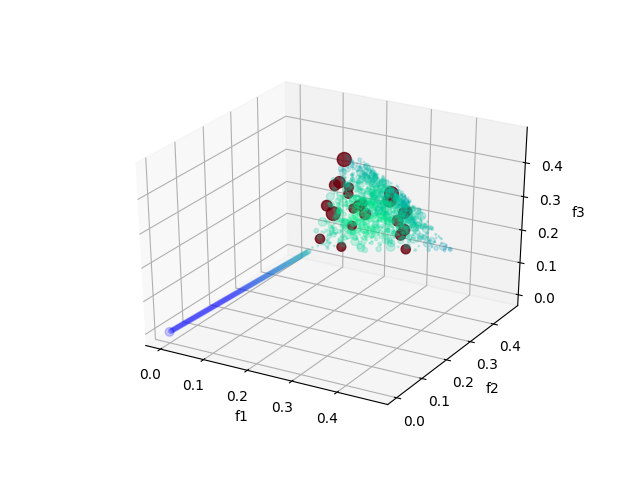

In [7]:
# use the original obj values for scatter plot.
rawpoints = fmt.load(rawfpath)
# do the scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)
# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter.pdf")
plt.savefig(scatterfpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


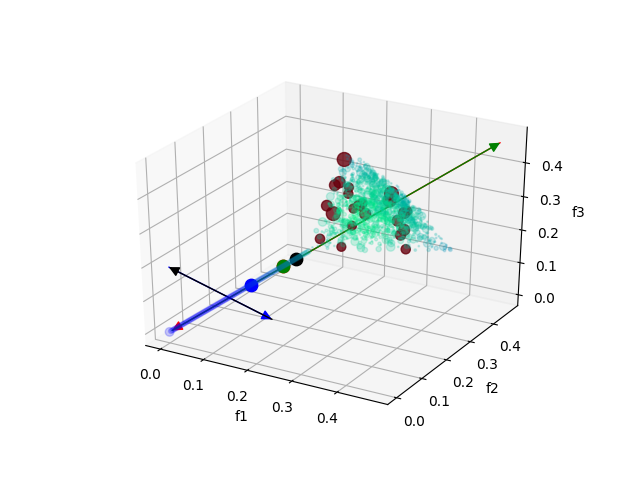

[0.1966705283172906, 0.19582633426358098, 0.19385879612281637, 0.413644341296312]
[0.1966705283172906, 0.19582633426358098, 0.19385879612281637, 0.413644341296312]
[0.18749999999999997, 0.18749999999999997, 0.25, 0.37499999999999994]
[0.18749999999999997, 0.18749999999999997, 0.25, 0.37499999999999994]


In [8]:
import math
import numpy as np

# function for computing asf
def asf(f, z, w, rho = 0.0001):
    m = len(f)
    s, maxd = 0.0, float('-inf')
    for i in range(m):
        d = (f[i] - z[i]) / w[i]
        if d >= maxd:
            maxd = d
        s = s + d
    return maxd + (rho * s)

# Find the minimum ASF among all objective vectors
def minimize_asf(F, z, w, rho = 0.0001):
    minasf = [-1, float('inf')]
    for i,f in enumerate(F):
        asfv = asf(f, z, w, rho = rho)
        if asfv <= minasf[1]:
            minasf = [i, asfv]
    return minasf[0]

# First do a scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)

# find the ideal and nadir points
refd = []
[utopia, nadir] = vops.get_bound(rawpoints)
refd.append([nadir, utopia])
if len(rawpoints[0]) == 3:
    refd.append([[0.0, 0.0, 1.0], [0.33, 0.33, 0.0]])
    refd.append([[0.33, 0.33, 0.0], [0.0, 0.0, 1.0]])
elif len(rawpoints[0]) == 4:
    refd.append([utopia, nadir])
    refd.append([[0.0, 0.0, 0.2, 0.3], [0.15, 0.15, 0.0, 0.0]])
    refd.append([[0.15, 0.15, 0.0, 0.0], [0.0, 0.0, 0.2, 0.3]])

arrclr = ['red', 'green', 'blue', 'black']
for i,d in enumerate(refd):
    v = vops.sub(d[0], d[1])
    u = [math.fabs(x) for x in v]
    su = math.fsum(u)
    w = [x/su for x in u]
    print(w)
    a = Arrow3D([d[0][0], d[1][0]], [d[0][1], d[1][1]], [d[0][2], d[1][2]], \
                mutation_scale = 15, lw = 1, arrowstyle = "-|>", color = arrclr[i])
    ax.add_artist(a)

    j = minimize_asf(rawpoints, d[0], w, rho = 0.0)
    plt.scatter(rawpoints[j][0], rawpoints[j][1], zs = rawpoints[j][2], \
                c = arrclr[i], s = 80.0)

# # # save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter-asf.pdf")
plt.savefig(scatterfpath, transparent = False)
    
plt.show()

<IPython.core.display.Javascript object>


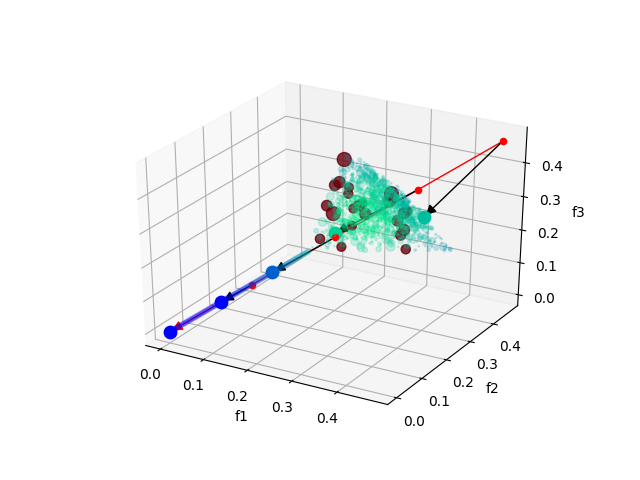

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [9]:
# Swap the last objective of two vectors to make the plot more dramatic
def swap_last(nadir, utopia):
    tmp = utopia[-1]
    utopia[-1] = nadir[-1]
    nadir[-1] = tmp

# First do a scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)

# find the ideal and nadir points
[utopia, nadir] = vops.get_bound(rawpoints)
swap_last(nadir, utopia)

# This is the direction that we want to go
a = Arrow3D([nadir[0], utopia[0]], [nadir[1], utopia[1]], [nadir[2], utopia[2]], \
            mutation_scale = 15, lw = 1, arrowstyle = "-|>", color = 'red')
ax.add_artist(a)

v = vops.sub(utopia, nadir)
d = vops.distlp(utopia, nadir)
u = vops.unit(v)
w = [1.0] * len(rawpoints[0])
scaling = [0.0, 0.25, 0.5, 0.75, 1.0]

asfsoln = []
for s in scaling:
    Zr = vops.add(nadir, vops.mult(u, d * s))
    plt.scatter(Zr[0], Zr[1], zs = Zr[2], c = 'red', s = 20.0)
    j = minimize_asf(rawpoints, Zr, w, rho = 0.0)
    plt.scatter(rawpoints[j][0], rawpoints[j][1], zs = rawpoints[j][2], \
                c = color[j], s = 80.0)
    a = Arrow3D([Zr[0], rawpoints[j][0]], \
                [Zr[1], rawpoints[j][1]], \
                [Zr[2], rawpoints[j][2]], \
                mutation_scale = 15, lw = 1, \
                arrowstyle = "-|>", color = 'black')
    ax.add_artist(a)
    asfsoln.append(j)
    
# # # save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter-path.pdf")
plt.savefig(scatterfpath, transparent = False)
    
plt.show()

<IPython.core.display.Javascript object>


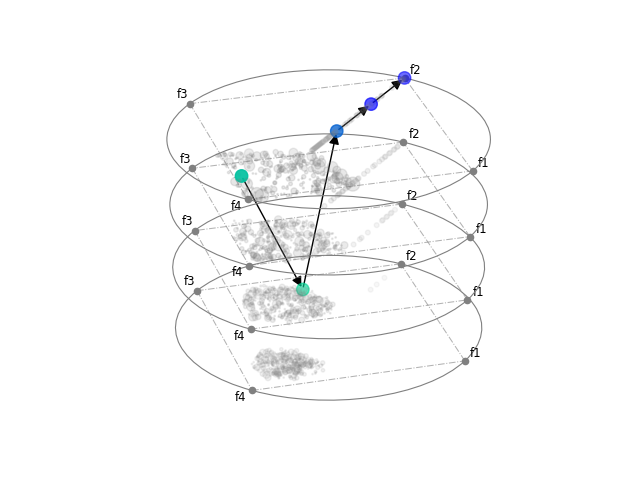

In [10]:
from matplotlib import colors

# Show the generic paletteviz
palette_coords = fmt.load(os.path.join(path, prefix + "-norm-palette-invsc.out"))

color_pr = []
size_pr = []
for i in range(len(color)):
    if i not in asfsoln:
        c = list(colors.to_rgba('grey'))
        c[-1] = 0.2
        color_pr.append(tuple(c))
        size_pr.append(size[i])
    else:
        color_pr.append(color[i])
        size_pr.append(80.0)

# do the paletteviz plot
(fig, ax) = pplt.paletteviz(palette_coords, dim = len(points[0]), \
            s = size_pr, c = color_pr, alpha = [None, None], \
            camera = dcor.cam_palette[prefix], \
            knee_idx = knee_idx, mode = "sc")

for i in range(len(asfsoln) - 1):
    from_ = palette_coords[asfsoln[i]]
    to_ = palette_coords[asfsoln[i+1]]
    a = Arrow3D([from_[0], to_[0]], [from_[1], to_[1]], [from_[2], to_[2]], \
                mutation_scale = 15, lw = 1, arrowstyle = "-|>", color = "black")
    ax.add_artist(a)

# save the paletteviz plot
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
palettefpath = os.path.join(".", prefix + "-norm-palette-invsc-path.pdf")
plt.savefig(palettefpath, transparent = False, bbox_inches = 'tight', pad_inches = 0)

plt.show()